# ~ ~ ~ Spectral Diagnostics using IBIS data ~ ~ ~ 

#### In this notebook

We will work with filtergraph (Fabry-Perot) observations made in three different spectral lines: 

- H$\alpha$, typical, very NLTE chromospheric spectral line. It is very weakly coupled to the local atmospheric conditions due to scattering, so it does not yield temperature information (or at least it seems so), but it is sensitive to velocity. 

- Ca II 8542, formed in the lower chromosphere, probing typically lower regions than H$\alpha$, more narrow so more usable for magnetic field diagnostics. Also typical NLTE line but somewhat coupled to temperature

- Na I D 1, typically probing photosphere and temperature minimum, again typical NLTE line formed by scattering so it only yields temperature information about photospheric layers. Usable for velocity and magnetic field diagnostics. 

In [1]:
# We will import some basic packages:

from astropy.io import fits
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# First we will open the most dramatic spectral line, H alpha
cube_halpha = fits.open("/home/milic/data/DKIST_workshop/velocities/halpha_ibis_ser1725.fits")[0].data
cube_halpha.shape

(1000, 1000, 46)

In [3]:
# We have 46 wavelenght points, at 1000 x 1000 pixels! (Each pixel is 0.096 arcsec)

Text(0.5, 1.0, 'Random Wavelength')

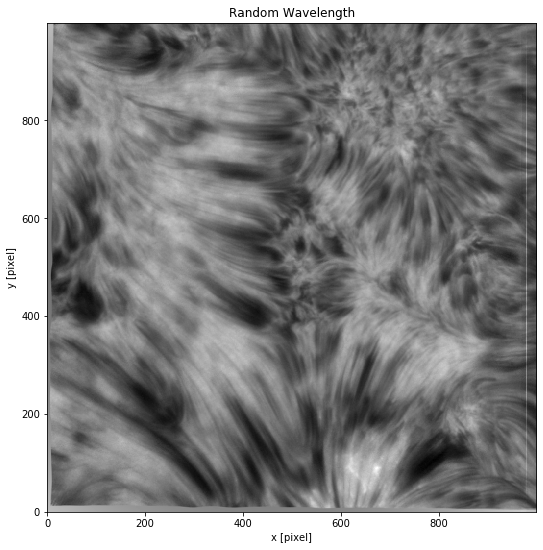

In [4]:
# Let's plot one wavelength to see if this makes sense. Image is basically spatial distribution of 
# the intensity at a fixed wavelength:
plt.figure(figsize=[9,9])
plt.imshow(cube_halpha[:,:,25].T,cmap='gray',origin='lower')
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.title("Random Wavelength")

Now, we will calculate to spatially averaged spectrum to see what are we dealing with here. It is good to see how our spectral line looks like. To plot that in  meaningful way we will also need wavelengths. They are in the same file:

In [5]:
ll_halpha = fits.open("/home/milic/data/DKIST_workshop/velocities/halpha_ibis_ser1725.fits")[1].data
ll_halpha.shape

(46,)

46 wavelengthts for 46 wavelength points, looks good so far!

In [6]:
mean_spectrum = np.mean(cube_halpha,axis=(0,1))

Text(0.5, 1.0, 'Spatially averaged spectrum')

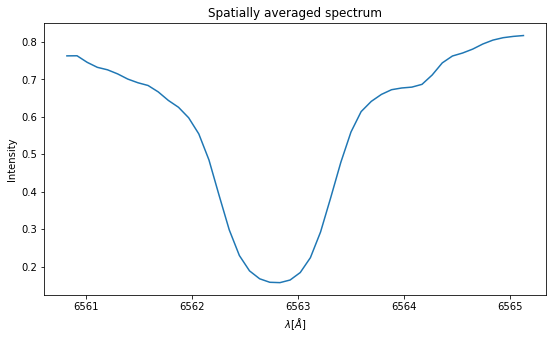

In [7]:
plt.figure(figsize=[9,5])
plt.plot(ll_halpha,mean_spectrum)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")
plt.title("Spatially averaged spectrum")

Looks like H$\alpha$ indeed! Discuss a little bit the line shape here. Also the wing extension (or lack thereof)

#### Now, in the next chapter we will find the center of the line as the minimum of the mean spectrum. We will do that by fitting a parabola through 5 points around the perceived center of the line (the point if with minimum intensity). Note that this is more precise than just picking the wavelength with minimum intensity. 

In [8]:
indmin = np.argmin(mean_spectrum) #Index of the point with minimum intensity:
print (indmin) # test if that makes sense

# Fit a parabola (polynomial of degree 2, through a couple of points each side of center)
p = np.polyfit(ll_halpha[indmin-2:indmin+3],mean_spectrum[indmin-2:indmin+3],2)

# Location of the minimum is -b/2a where y = ax^2 + bx + c
ll0 = -p[1]/2/p[0]
print (ll0)

21
6562.791885610779


We all know by hard magical numbers of Halpha line center 6562.8, and this is very close to it. (Probably someone already calibrated the data). It did not have to be, and it is always good to re-center your observations to what you think is the rest wavelength. 

#### Now let's plot images at a few different wavelengths, to confirm Ivan's favorite sentence: "Different wavelengths probe different depths" 

Text(0.5, 1.0, 'Wavelength = 0.03974005867348751')

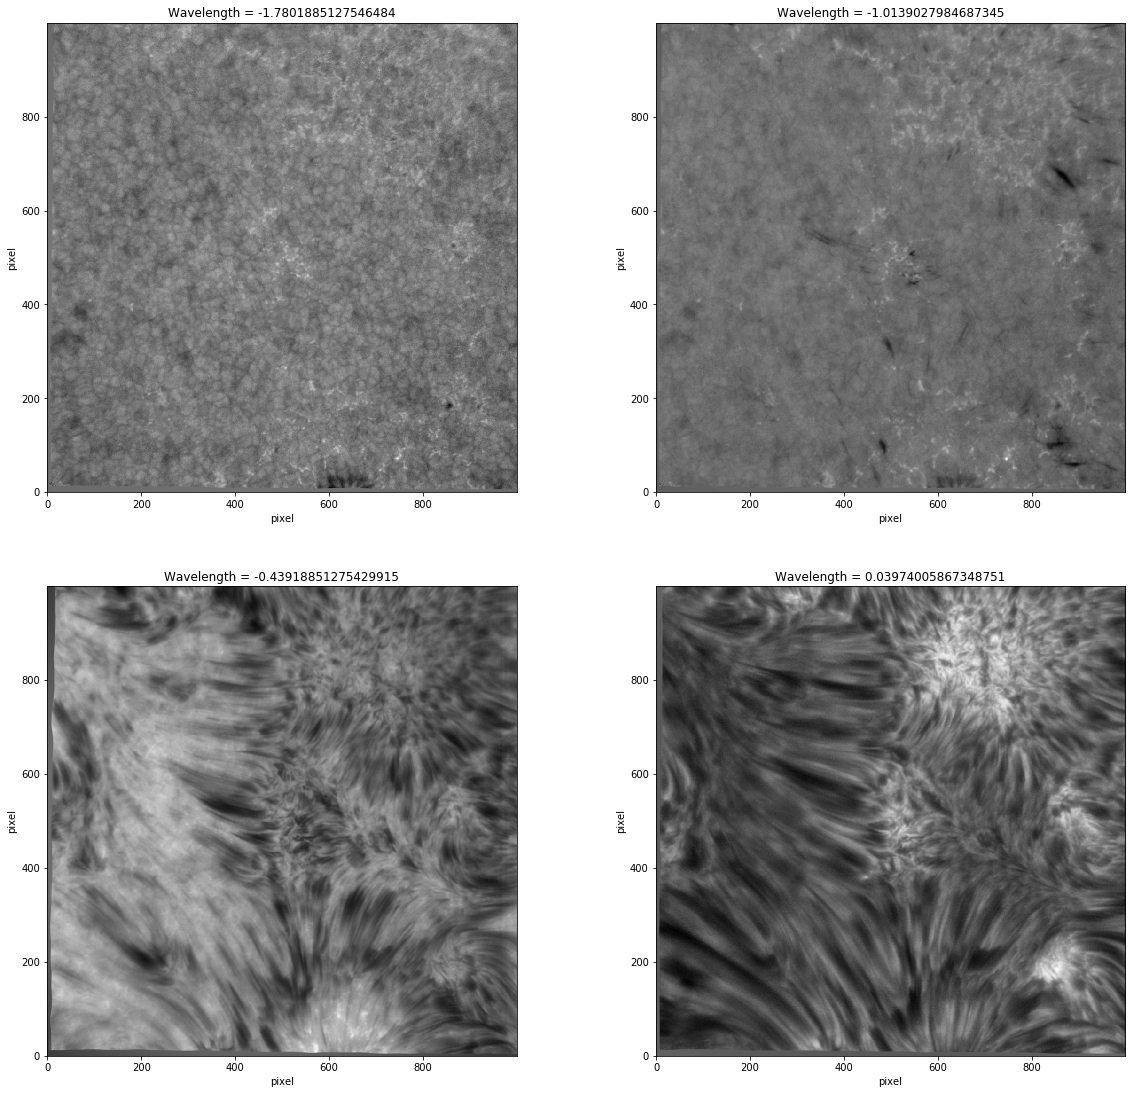

In [9]:
# Let's plot one wavelength to see if this makes sense
plt.figure(figsize=[20,19])
plt.subplot(221)
plt.imshow(cube_halpha[:,:,2].T,cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[2]-ll0))
plt.subplot(222)
plt.imshow(cube_halpha[:,:,10].T,cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[10]-ll0))
plt.subplot(223)
plt.imshow(cube_halpha[:,:,16].T,cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[16]-ll0))
plt.subplot(224)
plt.imshow(cube_halpha[:,:,21].T,cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[21]-ll0))

Now, another way of thinking about this multi-wavelength images is to say we got a spectrum for each pixel. If you don't trust us, let's have a look at that, we have 1000 x 1000 pixels indexed fom 0 to 999, so let's pick some random indices and plot these spectra

In [10]:
sample_x = np.random.choice(999,10)
sample_y = np.random.choice(999,10)
print (sample_x, sample_y)

[974 908 632 368 841 917 409 416 377 448] [ 50 847 683 308 974 798 231  93 472 860]


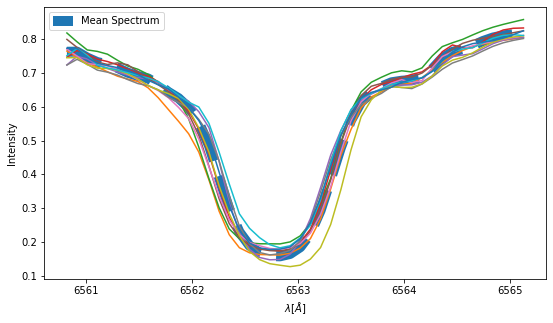

In [11]:
plt.figure(figsize=[9,5])
plt.plot(ll_halpha,mean_spectrum,'--',linewidth=10,label='Mean Spectrum')
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")
for i in range(0,10):
    plt.plot(ll_halpha,cube_halpha[sample_x[i],sample_y[i],:])
plt.legend()

### Why are the spectra different? 
#### Think about the following: 
- Line center position
- Line asymmetry 
- "Continuum" level
- Line core level
- Line width

## Finding velocities as the line center position shift

If you look at the above, you will see that he positions of the line centers (minima) are slightly different for each pixel. If we say that is is some representative velocity "seen" by H$\alpha$ line, we can use this to infer velocity via Doppler effect. 

#### What are some conceptual problems with this? 

.

.

.
#### Even with all these, we will get some idea of the velocity. Let's use the concept from the above (fitting the parabola around the line core), to infer velocities for each pixel. 

In [12]:
def calc_line_center(spectrum, wavelength):
    indmin = np.argmin(spectrum) #Index of the point with minimum intensity:
    
    # Fit a parabola (polynomial of degree 2, through a couple of points each side of center)
    p = np.polyfit(wavelength[indmin-2:indmin+3],spectrum[indmin-2:indmin+3],2)
    
    l_center = -p[1]/2/p[0]
    return l_center

In [13]:
# Let's try on a random spectrum and see if it makes sense: 
l_center_random = calc_line_center(cube_halpha[625,128],ll_halpha)
print (l_center_random)

6562.787157484033


In [14]:
# Looks reasonable, what velocity would this be? 
c = 2.997E5 # in km/s
v_test = (l_center_random-ll0)/ll0 *c 
print (v_test)

-0.2159171905070751


Not a huge velocity! Proper way to do this would be to use it on the whole map, so that we can plot velocity maps. 

In [18]:
line_centers = np.zeros([1000,1000])
for i in range(0,1000):
    for j in range(0,1000):
        line_centers[i,j] = calc_line_center(cube_halpha[i,j],ll_halpha)

In [19]:
v_line_center = (line_centers - ll0)/ll0 * c

Text(0, 0.5, 'y [pix]')

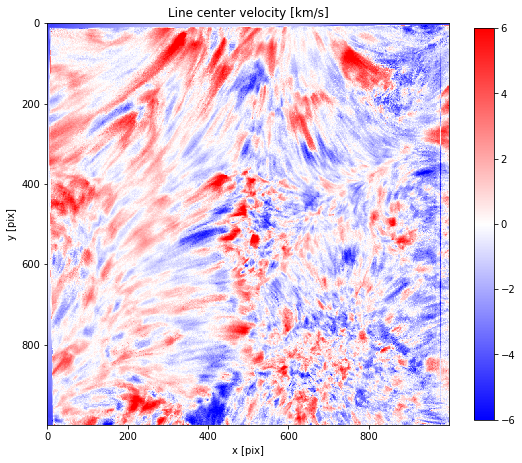

In [20]:
# And let's plot the velocity map! Exciting!
plt.figure(figsize=[9,9])
plt.imshow(v_line_center.T,vmin=-6,vmax=6,cmap='bwr')
plt.colorbar(shrink=0.8)
plt.title("Line center velocity [km/s]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

### Let's spend some time discussing this. What do these velocities mean? What do they tell us? What are the advantages and disadvantages of this approach?

After we are done with these, we can play and visualize a little bit this, but we can also move toward a more sophisticated method:

## Finding velocity via bisectors!!!!

In [23]:
# Let's go toward the hardest mode first! Bisectors!
levels = np.asarray([0.6,0.5,0.4,0.3])

In [24]:
def calc_bisectors(spectrum,wavelength,levels):
    # this is the function that takes in the spectrum, wavelength and desired bisector levels
    # and returns the position of the center of the horizontal line that connects the points 
    # of the desired from both sides of the >>local<< line center (meanining the point with min intensity)
    from scipy.interpolate import interp1d
    
    local_min = np.argmin(spectrum)
    
    result = np.zeros(len(levels))
    
    for i in range(0,len(levels)):
        f = interp1d(spectrum[:local_min],wavelength[:local_min])
        left_position = f(levels[i])
        f = interp1d(spectrum[local_min:],wavelength[local_min:])
        right_position = f(levels[i])
        result[i] = (right_position + left_position)*0.5
        
    return result

In [25]:
test = calc_bisectors(cube_halpha[517,715],ll_halpha,levels)

In [26]:
print (test)

[6562.78549365 6562.80874057 6562.81089364 6562.80900945]


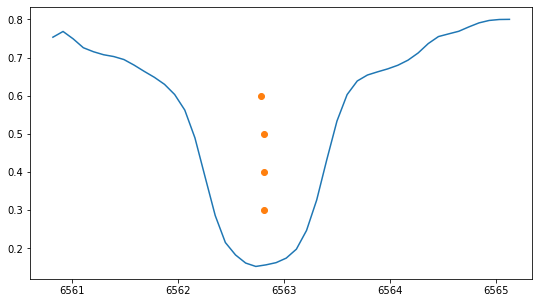

In [27]:
plt.figure(figsize=[9,5])
plt.plot(ll_halpha,cube_halpha[517,715])
plt.plot(test,levels,'o')

In [28]:
# Translate bisectors to velocities:
bisector_velocities = (test-ll0)/ll0 * 2.997E5

In [29]:
print (bisector_velocities)
print (ll0)

[-0.29189874  0.76970781  0.86803076  0.78198669]
6562.791885610779


In [35]:
bisectors = np.zeros([1000,1000,4])
for i in range(0,1000):
    for j in range(0,1000):
        bisectors[i,j,:] = calc_bisectors(cube_halpha[i,j,:],ll_halpha,levels)

In [31]:
bisector_velocities = (bisectors-ll0)/ll0 * 2.997E5

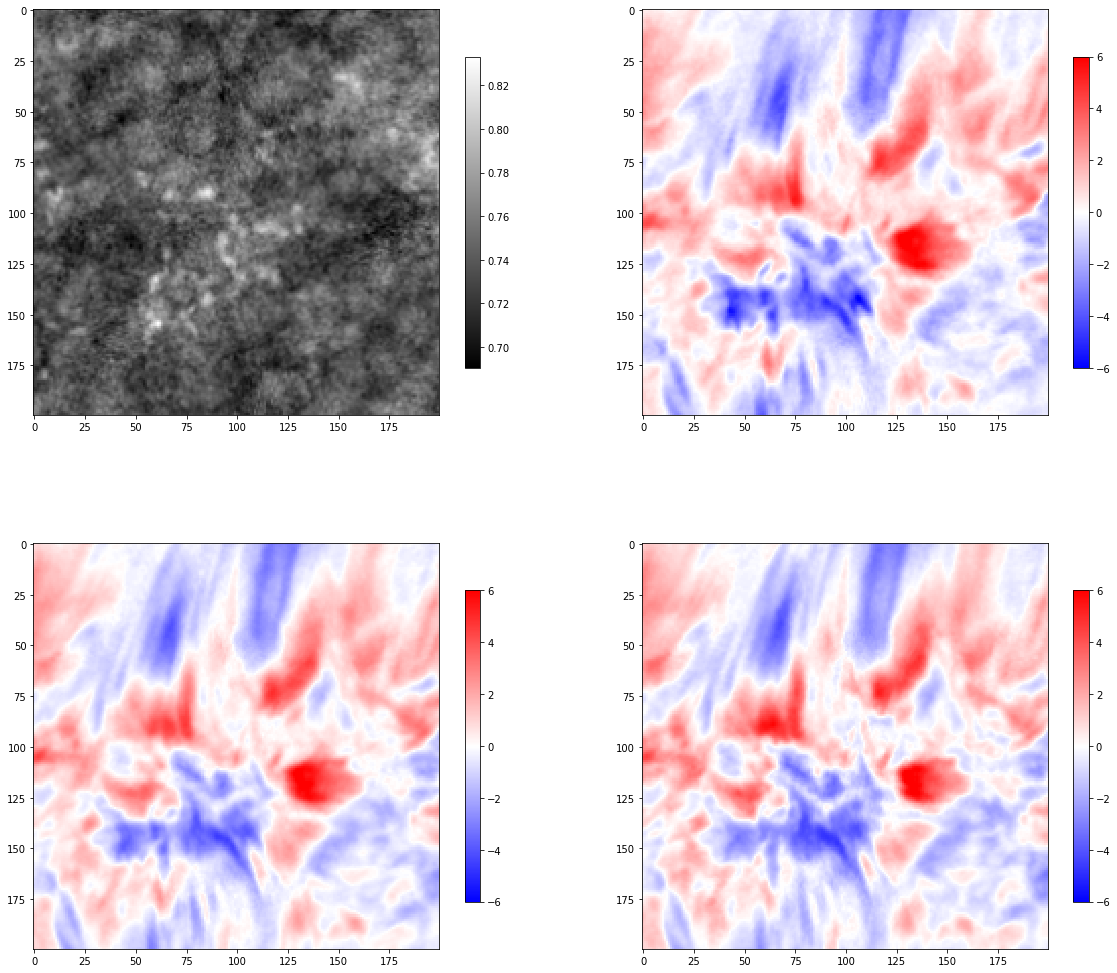

In [32]:
plt.figure(figsize=[20,18])
plt.subplot(221)
plt.imshow(cube_halpha[400:600,400:600,0],cmap='gray')
plt.colorbar(shrink=0.7)
plt.subplot(222)
plt.imshow(bisector_velocities[:,:,1],cmap='bwr',vmin=-6,vmax=6)
plt.colorbar(shrink=0.7)
plt.subplot(223)
plt.imshow(bisector_velocities[:,:,2],cmap='bwr',vmin=-6,vmax=6)
plt.colorbar(shrink=0.7)
plt.subplot(224)
plt.imshow(bisector_velocities[:,:,3],cmap='bwr',vmin=-6,vmax=6)
plt.colorbar(shrink=0.7)